<a href="https://colab.research.google.com/github/RogueArt/ECE188DeepLearning/blob/main/Adversarial_Example_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras.

We also import the image from our Google Drive.

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [ ]:
image_raw = tf.io.read_file('/content/drive/MyDrive/School/ECE 188/Project 2 Images/panda_bear.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

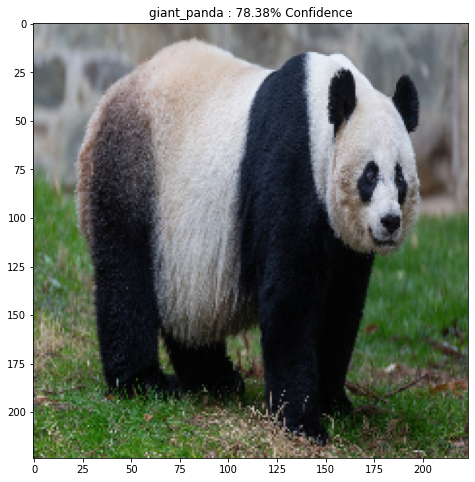

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

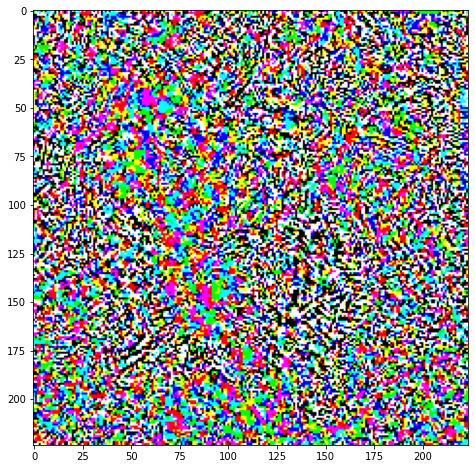

In [ ]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

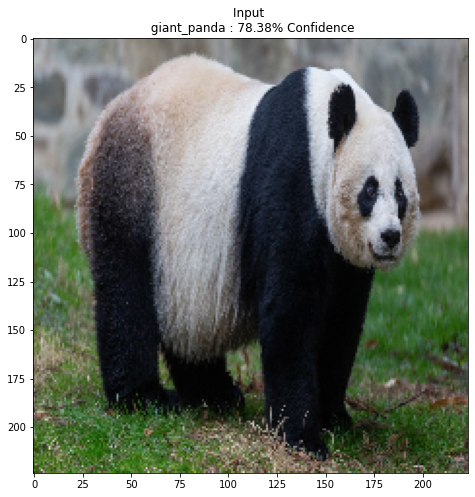

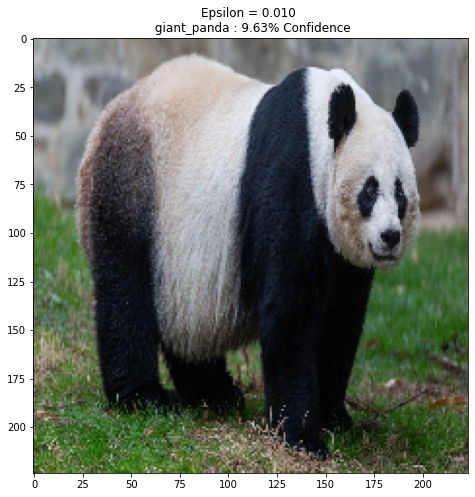

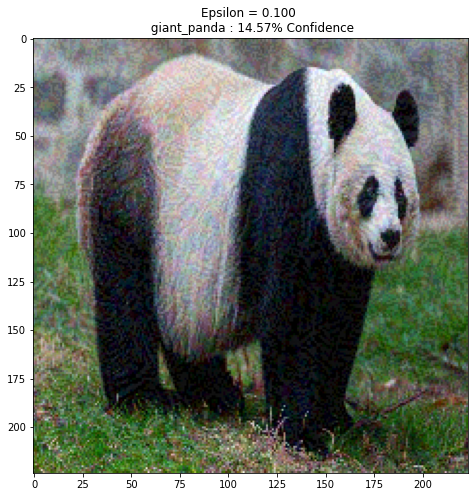

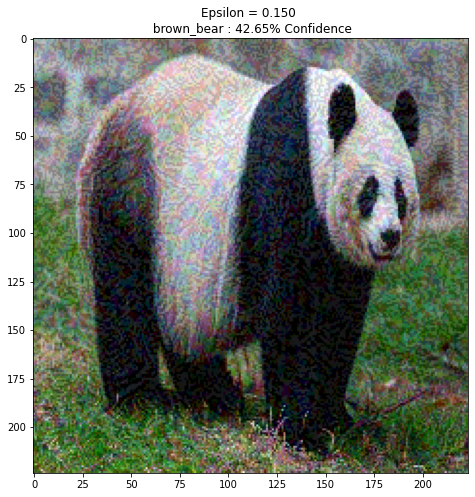

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task 2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [ ]:
# CONFIGURATION
SIG_FIGS = 4 # Number of sig figs in output

In [ ]:
from google.colab import data_table
import pandas as pd

# <======== HELPER METHODS ========>
# <== SHARED ==>
def get_label_from_image_path(image_path):
  start_idx = image_path.index('_') + 1
  end_idx = image_path.index('.')

  return image_path[start_idx:end_idx]

def to_title_case_from_snake_case(str):
  str_as_list = str.split('_')
  str_as_capital_list = list(map(lambda s: s.capitalize(), str_as_list))
  title_case_str = ' '.join(str_as_capital_list)
  return title_case_str

# <== 1. Load 10 images from different classes ==>
def load_images(image_base_path, images_info, pretrained_model, preprocess_options):
  processed_images = []
  for image_info in images_info:
    # Read and process the image
    image_raw = tf.io.read_file(image_base_path + image_info['path'])
    image = tf.image.decode_image(image_raw)

    # a) Image
    if preprocess_options is None:
      image = preprocess(image)
    else:
      image = custom_preprocess(image, preprocess_options['fn'], preprocess_options['size'])
    # b) Image probabilities
    image_probs = pretrained_model.predict(image)
    # c) Label index
    index = image_info['index']
    # d) Label name
    label_name = get_label_from_image_path(image_info['path'])

    # Append processed image to list
    processed_images.append((image, image_probs, index, label_name))

  return processed_images

# <== 2. 
# 2. Create adversarial perturbation for each image
def get_image_perturbations(images_info, pretrained_model):
  image_perturbations = []
  for image_info in images_info:
    # Extract information from tuple
    image, image_probs, index, label_name = image_info

    # Get the input label of the image.
    label = tf.one_hot(index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    perturbations = custom_create_adversarial_pattern(pretrained_model, image, label)
    image_perturbations.append(perturbations)

  return image_perturbations

# 3. Find the lowest epsilon for one image via binary search
CORRECTION_FACTOR = 5 / (10 ** (SIG_FIGS + 1))
def find_lowest_epsilon(expected_label: str, image, perturbations, pretrained_model):
  # Constants throughout loop
  epsilon, previous_epsilon = (0.0, 1.0)
  left, right = (0.0, 1.0)

  # print(f"Finding lowest epsilon values for {pretrained_model.name}")
  _, predicted_label, confidence = get_imagenet_label(pretrained_model.predict(image))
  # print("Original label is - Predicted: ", predicted_label, " - Expected: ", expected_label)

  while True:
    epsilon = (left + right)/2

    # Perturb the image by current epsilon value
    adv_x = image + perturbations * epsilon
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, predicted_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))

    # Binary search based on predicted label
    if predicted_label == expected_label:
      left = epsilon
    else:
      right = epsilon

    # Break if the values of epsilon for the first 4
    # decimal places have been the same in previous 2
    # iterations
    if round(epsilon, SIG_FIGS) == round(previous_epsilon, SIG_FIGS):
      break
    
    # Update epsilon value
    previous_epsilon = epsilon

  # Round lowest epsilon to 4 sig figs
  return round(epsilon + CORRECTION_FACTOR, SIG_FIGS)

def find_all_lowest_epsilons(images_info, image_perturbations, pretrained_model, label_epsilon_map = {}):  
  for i in range(0, len(images_info)):
    # Get lowest epsilon value
    label_name = images_info[i][3]
    image = images_info[i][0]
    lowest_epsilon = find_lowest_epsilon(label_name, image, image_perturbations[i], pretrained_model)

    # Add it to our dictionary
    if label_name not in label_epsilon_map:
      label_epsilon_map[label_name] = []

    label_epsilon_map[label_name].append(lowest_epsilon)  

  # Return this dictionary
  return label_epsilon_map

# 4. Make a table with all of this data
def create_table(lowest_epsilon_map, index):
  # Format the label names
  label_names = lowest_epsilon_map.keys()
  label_names = [to_title_case_from_snake_case(label_name) for label_name in label_names]

  # Transpose the values so it's display correctly in table
  lowest_epsilon_values = lowest_epsilon_map.values()
  lowest_epsilon_values = pd.DataFrame(lowest_epsilon_values).T.values.tolist()

  # Format the data frame  
  data_table.enable_dataframe_formatter()
  df = pd.DataFrame(lowest_epsilon_values, columns=label_names, index=index)
  df.index.name = 'Model Name'
  df.style.set_caption = 'Epsilon Values to Change Class For Each Label by Model Name'

  return df

def column(matrix, i):
  return [row[i] for row in matrix]

def custom_preprocess(image, fn, size):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size)
  image = fn(image)
  image = image[None, ...]
  return image

def custom_create_adversarial_pattern(pretrained_model, input_image, input_label):
  # print("Pretrained model name is in create adversarial pattern:", pretrained_model.name)
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def myTrunc(theNumber, theDigits):

    myDigits = 10 ** theDigits
    return (int(theNumber * myDigits) / myDigits)

# label_a: [a b c]
# label_b: [d e f]
# label_c: [g h i]

# [a b c], [d e f], [g h i]

# [a d g], [b e h], [c f i]

In [ ]:
# 1. Pick 10 images from different classes in Image Net
IMAGES_PATH_AND_INDEX = [{'path': 'n01440764_tench.JPEG', 'index': 0}, {'path': 'n02950826_cannon.JPEG', 'index': 471}, 
                         {'path': 'n02137549_mongoose.JPEG', 'index': 298 }, {'path': 'n01806143_peacock.JPEG', 'index': 84},
                         {'path': 'n03445777_golf_ball.JPEG', 'index': 574}, {'path': 'n02504013_Indian_elephant.JPEG', 'index': 385},
                         {'path': 'n03000247_chain_mail.JPEG', 'index': 490}, {'path': 'n03249569_drum.JPEG', 'index': 541},
                         {'path': 'n07742313_Granny_Smith.JPEG', 'index': 656}, {'path': 'n03935335_piggy_bank.JPEG', 'index': 719}]
IMAGE_BASE_PATH = '/content/drive/MyDrive/School/ECE 188/Project 2 Images/'

# 2. Perform perturbation analysis on these images
def perform_task_2(pretrained_model, label_epsilon_map = {}, preprocess_options = None):
  images_info = load_images(IMAGE_BASE_PATH, IMAGES_PATH_AND_INDEX, pretrained_model, preprocess_options)
  image_perturbations = get_image_perturbations(images_info, pretrained_model)

  # 3. Get the lowest epsilon values for each image
  label_epsilon_map = find_all_lowest_epsilons(images_info, image_perturbations, pretrained_model, label_epsilon_map)
  return label_epsilon_map

# 4. Create a table showing these values
label_epsilon_map = perform_task_2(pretrained_model)
create_table(label_epsilon_map, ['MobileNetV2'])

,Tench,Cannon,Mongoose,Peacock,Golf Ball,Indian Elephant,Chain Mail,Drum,Granny Smith,Piggy Bank
Model Name,,,,,,,,,,
MobileNetV2,0.1303,0.2219,0.0036,0.5708,0.0059,0.0037,0.1649,0.0086,0.0193,0.2213


# Task 3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [ ]:
# <=== CORRECTION ===>+
# 1. Consider 5 different models
# 2. Load the pre-trained weights for ImageNet
# NOTE: I extracted loading the models into a separate part as we can cache this
MODEL_LIST_TASK_3 = [
                      [tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet'), 'mobilenet_v2', (224, 224), 'MobileNetV2'], 
                      [tf.keras.applications.NASNetMobile(include_top=True, weights='imagenet'), 'nasnet', (224, 224), 'NASNetMobile'],
                      [tf.keras.applications.ResNet50V2(include_top=True, weights='imagenet'), 'resnet_v2', (224, 224), 'ResNetV2'],
                      [tf.keras.applications.ResNet152V2(include_top=True, weights='imagenet'), 'resnet_v2', (224, 224), 'ResNet152V2'],
                      [tf.keras.applications.Xception(include_top=True, weights='imagenet'), 'xception', (299, 299), 'Xception'],
                      [tf.keras.applications.InceptionV3(include_top=True, weights='imagenet'), 'inception_v3', (299, 299), 'InceptionV3'],
]

242761728/242745792 [==============================] - 2s 0us/step


In [ ]:
import traceback

# 3. Perform Task2 on all the conosidered models
# 4. Add all results in the table
def perform_task_3():
  label_epsilon_map = {}
  for (model, internal_model_name, size, display_model_name) in MODEL_LIST_TASK_3:
    # Update the model
    pretrained_model = model
    pretrained_model.trainable = False
    application = getattr(tf.keras.applications, internal_model_name)
    decode_predictions = application.decode_predictions
    
    preprocess_fn = application.preprocess_input
    preprocess_options = {
        'fn': preprocess_fn,
        'size': size,
    }
    
    # Perform task 2 on new model
    print("Starting adversarial attack on model", pretrained_model.name),
    label_epsilon_map = perform_task_2(pretrained_model, label_epsilon_map, preprocess_options)

  # Create table showing all models
  return label_epsilon_map

label_epsilon_map = perform_task_3()
create_table(label_epsilon_map, column(MODEL_LIST_TASK_3, 3))

Starting adversarial attack on model mobilenetv2_1.00_224
Starting adversarial attack on model NASNet
Starting adversarial attack on model resnet50v2
Starting adversarial attack on model resnet152v2
Starting adversarial attack on model xception
Starting adversarial attack on model inception_v3


,Tench,Cannon,Mongoose,Peacock,Golf Ball,Indian Elephant,Chain Mail,Drum,Granny Smith,Piggy Bank
Model Name,,,,,,,,,,
MobileNetV2,0.1303,0.2219,0.0036,0.5708,0.0059,0.0037,0.1649,0.0086,0.0193,0.2213
NASNetMobile,0.2458,0.1397,0.0076,0.2349,0.1532,0.0029,0.0040,0.0038,0.0034,0.4182
ResNetV2,0.3113,0.0060,0.0037,0.0051,0.1429,0.0006,0.0207,0.6529,0.0281,0.1416
ResNet152V2,0.0017,0.3636,0.0069,0.0071,0.1367,0.0021,0.2767,0.0006,0.1888,0.4209
Xception,0.0022,0.4866,0.0019,0.0027,0.1919,0.0022,0.2381,0.5970,0.0134,0.4358
InceptionV3,0.6671,0.4601,0.1290,0.1302,0.1936,0.0013,0.0482,0.0034,0.4002,0.4666


**What do you observe? Why do you think this is the case?**
The amount of noise to cause misidentification varies depending on the class. For example, classes that have images or objects similar to other classes e.g. an Indian elephant can be mistaken for an African elephant, a drum for a tambourine, etc. tend to be more susceptible to noise. However, classes that are uniquely identifiable such as a piggy bank are much more resilient overall.

Additionally, models that take in larger images and have more layers tend to be more resilient to the adversarial attacks. For example, Xception and Inception both use image sizes of 299x299 instead of 244x244 and they seem to be significantly more resilient to noise than most other models. Interestingly, it seems that models with more laeyrs are not necessarily more resilient. For example, both ResNetV2 and ResNet152V2 have double the amount of layers as Xception and Inception and triple the amount of MobileNetV2, but they seem to perform worse on average than the aforementioned models. One thought I had is that it's possible that having more layers results in noise propagating farther causing greater misidentification which is why we see high accuracy with models that have lots of layers, but low resilience to noise.

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 